### Load all

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
# import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

2024-08-12 15:11:39.940642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:11:39.940683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:11:39.940717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 15:11:40.933403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[15:11:41] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=596419;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=565765;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=847756;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=309114;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=24286;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=366378;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/sruthi/Documents/thesis/distributional-sr/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, se

In [3]:
# My codes
import decoder_PC2d
import model_viz6_functions as modelviz_utils
# from model_viz6_functions import plot_samples 

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/sruthi/Documents/thesis/distributional-sr/dsm/train.py:115: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-ty

### ENV and MODEL path and CONFIGs here

In [4]:
ENVIRONMENT = "Ratinabox-v0-pc-teleport" 
model_path = "logdir-rat_50pc_teleport" 

In [5]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [6]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (12000, 50)
NUM_STATE_DIM_CELLS: 50


In [7]:
# env = envs.make(ENVIRONMENT) 
# dir(env)

### Input xs - create dataset of place cell activations over the whole env

In [8]:
# env_coords = Ag.Environment.flattened_discrete_coords #(10000, 2)
env_coords = Ag.Environment.discretise_environment(dx=0.01) # dx=Ag.environment.scale/10 , dx=0.01
env_coords = env_coords.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
pc_full_env = PCs.get_state(evaluate_at=None, pos=env_coords).T
pc_full_env.shape

(10000, 50)

### Decode position from PC activity

In [9]:
# dataset_positions = decoder_PC2d.simple_decode_position(dataset.observation,env_coords,pc_full_env,plot=True)
# # WORKS only when dx=0.01 in Ag.Environment.discretise_environment(dx=0.01) ?
# print(dataset_positions.shape)

env_coords shape to train decoder:  (10000, 2)
GaussianProcessRegressor trained


/home/sruthi/Documents/thesis/distributional-sr/decoder_PC2d.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.00974627 0.00974627]
 [0.00958173 0.00958173]
 [0.00998056 0.00998056]
 ...
 [0.01022113 0.01022113]
 [0.01010856 0.01010856]
 [0.01315143 0.01315143]]


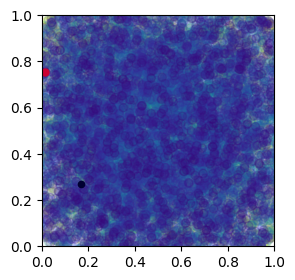

In [10]:
decoder_PC2d.train_decoder(PCs,env_coords=env_coords, method='GP') # GP
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='GP')
positions_pred, positions_std = decoder_PC2d.decode_position(PCs,dataset.observation, method='GP',return_std=True)
print('positions_std',positions_std)

/home/sruthi/Documents/thesis/distributional-sr/decoder_PC2d.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.04324947 0.0385515 ]
 [0.04505813 0.06043927]
 [0.03520374 0.03570022]
 ...
 [0.01499813 0.03418214]
 [0.03665378 0.03022859]
 [0.0642342  0.06916446]]


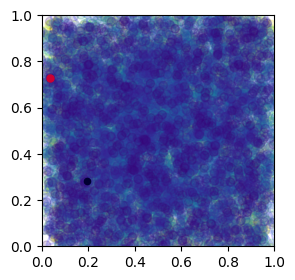

In [11]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=50)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

In [12]:
# decoder_PC2d.train_decoder(PCs,env_coords=env_coords, method='LR') # GP
# positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='LR')

In [13]:
# NUM_SECS = 1*60
# sel_dataset_positions = dataset_positions[:600]
# Ag.import_trajectory(times = np.linspace(0, NUM_SECS,len(sel_dataset_positions)), positions=sel_dataset_positions) #,interpolate=True
# for i in range(int(NUM_SECS / Ag.dt)):
#         Ag.update()
# Ag.plot_trajectory(color='changing',plot_head_direction=True)
# # Ag.plot_trajectory(framerate=1)

### Model stuff - restoring checkpoint

In [14]:
state, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env)

[15:12:55] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=638854;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=504958;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=712600;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=9436;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=374974;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=703958;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 500000


[15:13:02] INFO     Restoring item from                                                         ]8;id=659774;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=809179;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_teleport/50                    
                    0000.                                                                                          

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=956805;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=62671;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_teleport/50                    
                    0000.                                                                                          

In [15]:
print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 11, num_state_dims = 50)
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 


Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 55, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 50), 'kernel': (10, 32, 50)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 50
)>


atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

### compute DSM samples

In [16]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]


(100, 50)


In [17]:
# positions_all = decoder_PC2d.decode_position(PCs,source_states_env,plot=True)
# source_states_env_PCactivities = decoder_PC2d.simple_decode_position(source_states_env, env_coords, pc_full_env,plot=False)

source pos:  [0.35 0.95]
Max SD of samples decoded with dropoutNet(0.13579269, 0.20927724) ; Atom 1
Max SD of samples decoded with dropoutNet(0.16768984, 0.16569024) ; Atom 4
Max SD of samples decoded with dropoutNet(0.19059838, 0.16218458) ; Atom 5
Max SD of samples decoded with dropoutNet(0.109414786, 0.19390713) ; Atom 6
Max SD of samples decoded with dropoutNet(0.10012115, 0.13975205) ; Atom 8
decoded source:  [0.39328477 0.941912  ]


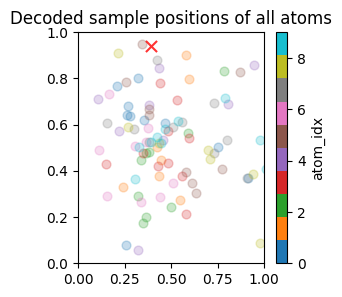

Max SD of samples decoded with dropoutNet(0.994838292385498, 0.994838292385498) ; Atom 0
Max SD of samples decoded with dropoutNet(0.943858118658615, 0.943858118658615) ; Atom 1
Max SD of samples decoded with dropoutNet(0.9507184543746995, 0.9507184543746995) ; Atom 2
Max SD of samples decoded with dropoutNet(0.9785642928032285, 0.9785642928032285) ; Atom 3
Max SD of samples decoded with dropoutNet(0.9994151592038533, 0.9994151592038533) ; Atom 4
Max SD of samples decoded with dropoutNet(0.9792368606365157, 0.9792368606365157) ; Atom 5
Max SD of samples decoded with dropoutNet(0.9925647232759196, 0.9925647232759196) ; Atom 6
Max SD of samples decoded with dropoutNet(0.9989991225095137, 0.9989991225095137) ; Atom 7
Max SD of samples decoded with dropoutNet(0.9633429555826256, 0.9633429555826256) ; Atom 8
Max SD of samples decoded with dropoutNet(0.974395717826849, 0.974395717826849) ; Atom 9
decoded source:  [0.34952447 0.95125411]


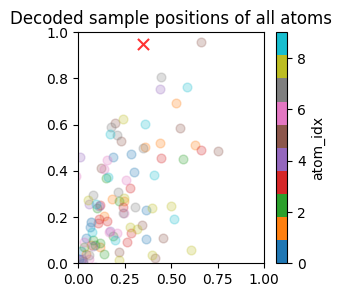

In [18]:
source_idx = 3
source=source_states_env[source_idx]
print('source pos: ',env_coords_small[source_idx])
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='GP')

In [19]:
# import importlib 
# importlib.reload(modelviz_utils)
# importlib.reload(decoder_PC2d)

SD of decoded samples with dropoutNet:[[0.12954932 0.17247424]
 [0.06997785 0.04503569]
 [0.03825436 0.05469419]
 [0.06963993 0.04179937]
 [0.02879908 0.02593628]
 [0.03126878 0.02302091]
 [0.02318417 0.05002235]
 [0.04300482 0.04055668]
 [0.03615284 0.02288785]
 [0.02424303 0.02095134]]
decoded source:  [0.39900804 0.86005336]


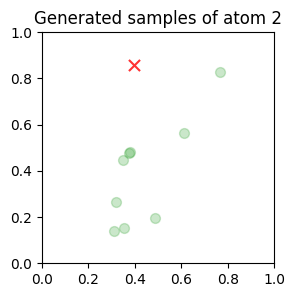

SD of decoded samples with dropoutNet:[[0.94076606 0.94076606]
 [0.81308986 0.81308986]
 [0.86489488 0.86489488]
 [0.87137606 0.87137606]
 [0.68699222 0.68699222]
 [0.95071845 0.95071845]
 [0.89090802 0.89090802]
 [0.90147977 0.90147977]
 [0.95008296 0.95008296]
 [0.76933752 0.76933752]]
decoded source:  [0.34952447 0.95125411]


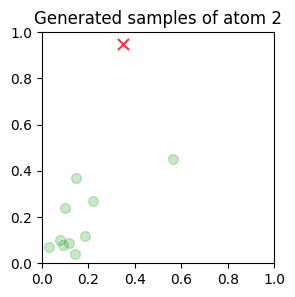

In [20]:
atom_idx = 2
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
print(f'SD of decoded samples with dropoutNet:{positions_std}')
# plot of positions_pred
modelviz_utils.plot_samples(PCs, dataset.observation, samples,source, make_dataset=False,atom=atom_idx,method='dropoutNet')

positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='GP',return_std=True)
print(f'SD of decoded samples with dropoutNet:{positions_std}')
modelviz_utils.plot_samples(PCs, dataset.observation, samples,source, make_dataset=False,atom=atom_idx,method='GP')


original source:  [0.05 0.75]
Max SD of samples decoded with dropoutNet(0.13954777, 0.1512686) ; Atom 1
Max SD of samples decoded with dropoutNet(0.123832725, 0.24395344) ; Atom 4
Max SD of samples decoded with dropoutNet(0.12472013, 0.13057682) ; Atom 5
Max SD of samples decoded with dropoutNet(0.1311258, 0.1955624) ; Atom 6
Max SD of samples decoded with dropoutNet(0.13140278, 0.1523151) ; Atom 8
decoded source:  [0.07273562 0.7142755 ]


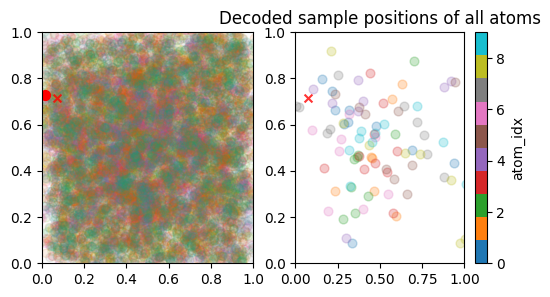

In [21]:
source_idx = 20
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
source, samples = modelviz_utils.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=True,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)

Decoder uncertainty

In [22]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = plt.get_cmap('tab10')

Max SD of decoded samples of atom 1 with dropoutNet: (0.13640626, 0.13023937)
Max SD of decoded samples of atom 2 with dropoutNet: (0.12631916, 0.13064861)
Max SD of decoded samples of atom 4 with dropoutNet: (0.21201496, 0.16629645)
Max SD of decoded samples of atom 6 with dropoutNet: (0.1571715, 0.22549503)
Max SD of decoded samples of atom 7 with dropoutNet: (0.11668116, 0.113129854)
Max SD of decoded samples of atom 8 with dropoutNet: (0.16679014, 0.11832716)


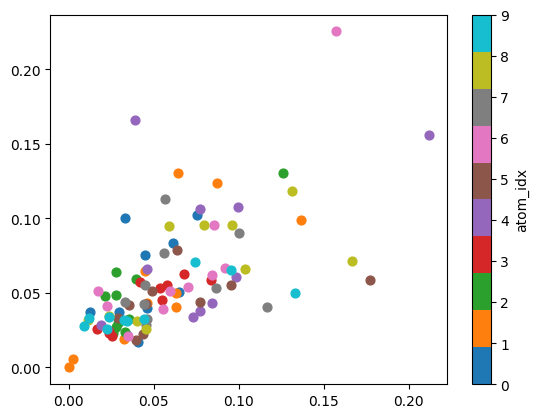

In [23]:
atom_idx_values = np.arange(10) #[3,4,8]
norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))

for atom_idx in atom_idx_values:
    positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
    plt.scatter(positions_std[:, 0], positions_std[:, 1], color=cmap(norm(atom_idx)), s=40)
    # range_column1 = (np.min(positions_std[:, 0]), np.max(positions_std[:, 0]))
    # range_column2 = (np.min(positions_std[:, 1]), np.max(positions_std[:, 1]))
    maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
    if maxc1 > 0.1 and maxc2 > 0.1:
        print(f'Max SD of decoded samples of atom {atom_idx} with dropoutNet: {maxc1, maxc2}')

# Create a ScalarMappable object and use it to add a colorbar to the plot
sm = ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca(), label='atom_idx')
plt.show()

### i_th Atom parameters

In [24]:
from model_viz6_functions import extract_params_ith_atom, predict_with_all_intermediates, predict_layer

# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 0  # ith atom
num_outer = config.num_outer 
atom_params = extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))


Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (55, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (50,), 'kernel': (32, 50)}}


## Plot intermediate activations of Atom


- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

## Single output per source state - fixed latent

In [25]:
# #TODO - select layer
# layers = ['Dense_0',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)
# neuron_idx = 48
# activations_selected = activations_neuron[:, neuron_idx]
# [activations_selected[i] for i in range(4, len(activations_selected),9)]
# plot_neuron_activations(activations_neuron,neuron_idx,layers)

In [26]:
from model_viz6_functions import compute_activation_layer_all_sources, compute_activation_allintermediates_1source, compute_activation_allintermediates_all_sources, plot_neuron_activations
num_latent_dims=config.latent_dims
source_states_env.shape
rng = jax.random.PRNGKey(0) #rng = np.random.default_rng(config.seed)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
(100, 50)


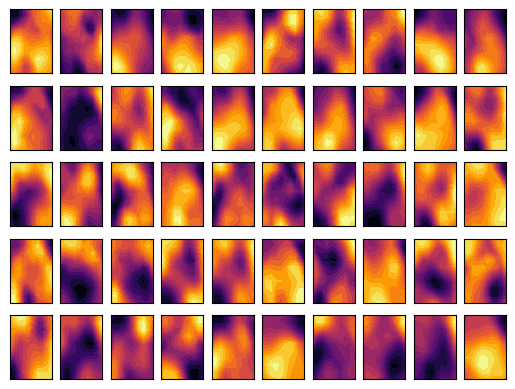

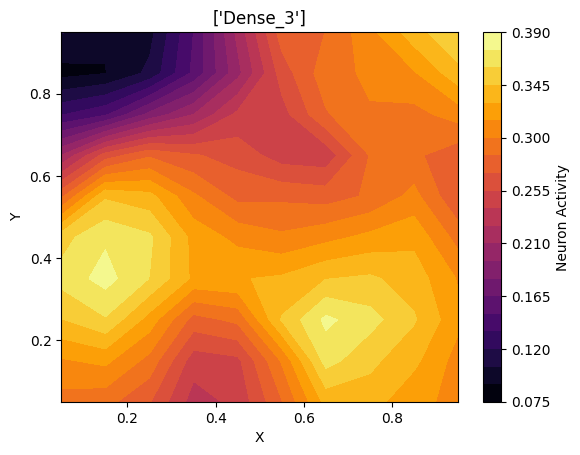

In [27]:
#### Dense 3 activations correspond to 50 PCs outputs; should look like place cell ratemaps - but different atoms?

layers = ['Dense_3',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)

activations_neurons_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    print('zs',zs)
    activations_neurons = compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_neurons_randomz.append(activations_neurons)
    print(activations_neurons.shape)

# neuron_idx = np.arange(activations_neuron.shape[-1])
# plot_neuron_activations(activations_neuron,neuron_idx,layers)
for i in range(len(activations_neurons_randomz)):
    neuron_idx = np.arange(activations_neurons_randomz[i].shape[-1])
    plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)
    neuron_idx=0
    plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)

### All intermediates

In [28]:
#TODO - select layer
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
rng = jax.random.PRNGKey(0)
zs = jax.random.normal(rng, (num_latent_dims,))
# zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
activations_alllayers = compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
# print(activations_alllayers['Dense_0'] )

In [29]:
joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# activations_alllayers = joblib.load('activations_alllayers_latent0.pkl')

['logdir-rat_50pc_teleport/activations_alllayers_latent_atom0.pkl']

### All Dense layers

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
(100, 50)


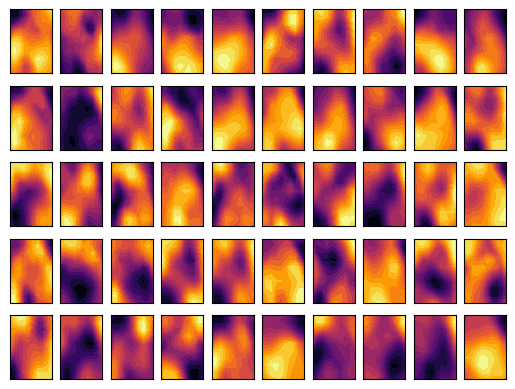

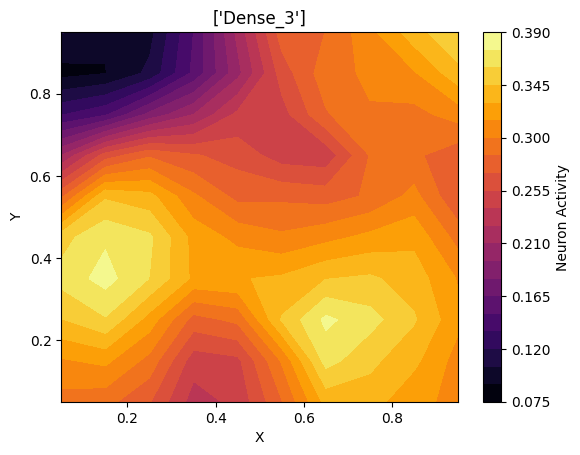

In [30]:
#### Dense 3 activations correspond to output - 50 place cells per source- 
# Here it should look like place cell ratemaps 
# - but different atoms?

layers = ['Dense_3',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)

activations_neurons_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    print('zs',zs)
    activations_neurons = compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_neurons_randomz.append(activations_neurons)
    print(activations_neurons.shape)

    # # neuron_idx = np.arange(activations_neuron.shape[-1])
    # # plot_neuron_activations(activations_neuron,neuron_idx,layers)
    # for i in range(len(activations_neurons_randomz)):

    neuron_idx = np.arange(activations_neurons_randomz[i].shape[-1])
    plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)
    neuron_idx=0
    plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)

### Different atom

(100, 50)


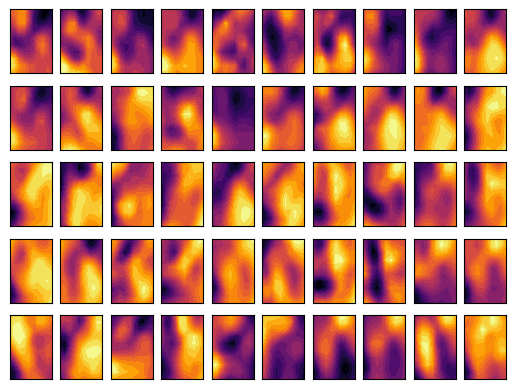

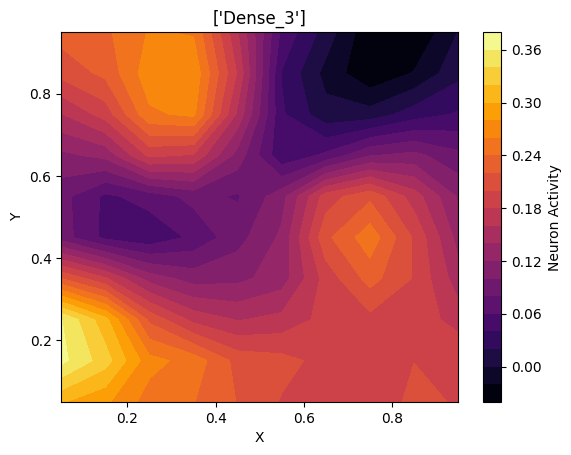

In [31]:
i = 4  # ith atom
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,)) 

atom_params = extract_params_ith_atom(state.generator, i, config.num_outer)
activations_neurons = compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
print(activations_neurons.shape)
neuron_idx = np.arange(activations_neurons.shape[-1])
plot_neuron_activations(activations_neurons,neuron_idx,layers,xpos,ypos)
neuron_idx=0
plot_neuron_activations(activations_neurons,neuron_idx,layers,xpos,ypos)

#### Dense 0,1,2

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


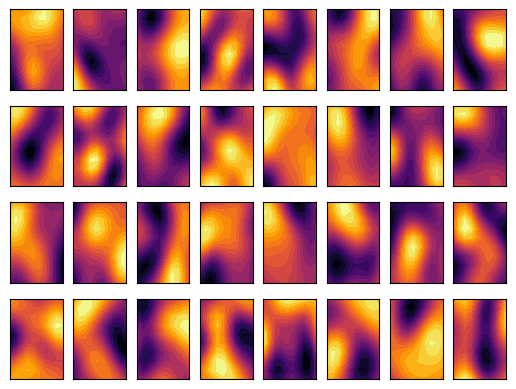

In [32]:
layers = ['Dense_0',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)

activations_neurons_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    print('zs',zs)
    activations_neurons = compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_neurons_randomz.append(activations_neurons)

activations_neuron = activations_neurons_randomz[0]
neuron_idx = np.arange(0, min(50,activations_neuron.shape[1]))
plot_neuron_activations(activations_neuron,neuron_idx,layers,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


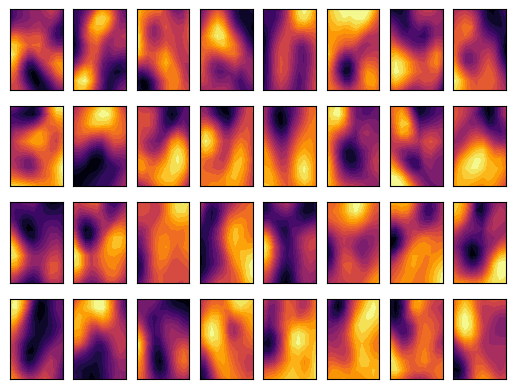

In [33]:
layers = ['Dense_1',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)

activations_neurons_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    print('zs',zs)
    activations_neurons = compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_neurons_randomz.append(activations_neurons)

activations_neuron = activations_neurons_randomz[0]
neuron_idx = np.arange(0, min(50,activations_neuron.shape[1]))
plot_neuron_activations(activations_neuron,neuron_idx,layers,xpos,ypos)

zs [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]
(100, 32)


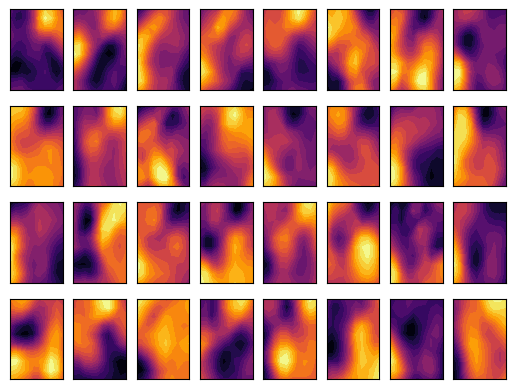

In [34]:
layers = ['Dense_2',]
# activations_neuron = compute_activation_layer_all_sources(atom_params, source_states_env, layers)
# print(activations_neuron.shape)

activations_neurons_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (num_latent_dims,))
    print('zs',zs)
    activations_neurons = compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    activations_neurons_randomz.append(activations_neurons)

    print(activations_neurons.shape)
    neuron_idx = np.arange(0, min(50,activations_neurons.shape[1]))
    plot_neuron_activations(activations_neurons,neuron_idx,layers,xpos,ypos)


## Later

- decoding from hidden neuron to start and end state, 
- tsne/ umap
- entropy

Model will generate different successor states from the same source state (effect of different latents?, try giving all 5 same?). \
Different source states may generate same successor states (same x,y positions) 

xs[:,:,-3:] #same - context - source state , rest noise latent dims  \
 xs_atom #shape (8)

In [35]:
# from model_viz6_functions import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(state.generator, atom_params, source_states_env, layers,num_samples,num_latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)